In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

from pointprocess import *
from lightning_setup import *
%matplotlib inline

In [2]:
c = Region(city=cities['cedar'])
c.SUBSETTED = False
c.CENTER = (37.7, -111.8)
c.RADIUS = 0.7

In [3]:
storm = '2010-07-20'

In [4]:
ds = c.get_daily_ds(storm, filter_CG=dict(method='CG'), func=None)

## Conditional rate of occurrence
This seemed important and useful enough to push into the module. 

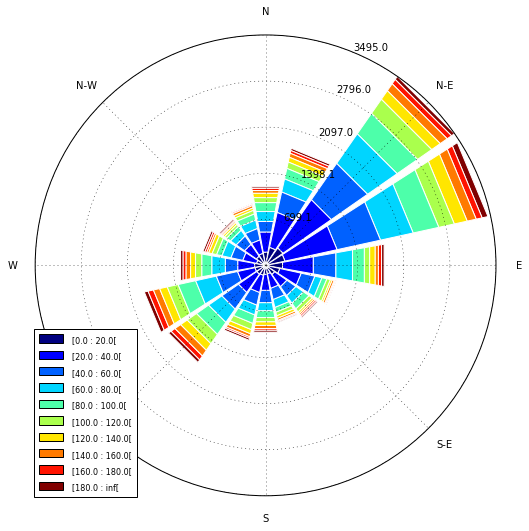

In [5]:
c.conditional_rate_of_occurrence(ds, normed=False);

An unclustered windrose would look like this:

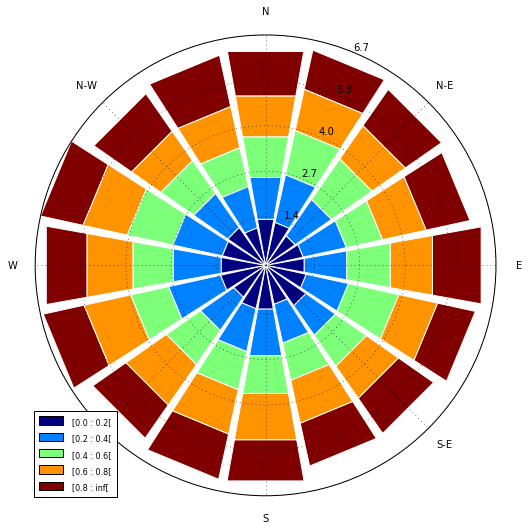

In [6]:
foo = pd.DataFrame(np.random.rand(10000, 2), columns=['speed', 'direction'])
foo['direction'] *= 360

from windrose import WindroseAxes
ax = WindroseAxes.from_ax()
ax.bar(foo['direction'], foo['speed'], bins=[0, .2, .4, .6, .8], normed=True, opening=0.9, edgecolor='white')
ax.set_legend()